# TFM - SHAP 

Using the Shap and a CNN previously developped for Deep Learning:

+ Developing a CNN model to classify X-ray images with high accuracy.
+ To explore classifier explanation methods.

In [1]:
import numpy as np 
import pandas as pd 

import os
import matplotlib.pyplot as plt

from tqdm import tqdm, tqdm_notebook
import tensorflow as tf
from sklearn.metrics import confusion_matrix
from tensorflow.keras.preprocessing import image
from tensorflow.keras import models, layers, optimizers, applications
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.models import Sequential, Model 
from tensorflow.keras.layers import Dropout, Flatten, Dense, GlobalAveragePooling2D,Conv2D,MaxPooling2D,GlobalMaxPooling2D, BatchNormalization
from tensorflow.keras.layers import Multiply, Dot, Concatenate, Input, UpSampling2D, LeakyReLU
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, TensorBoard, EarlyStopping
from sklearn.metrics import classification_report

from tensorflow.keras.optimizers import SGD
from sklearn.model_selection import train_test_split

from IPython.display import SVG
from tensorflow.keras.utils import model_to_dot


In [2]:
import shap

# load JS visualization code to notebook
shap.initjs()

In [3]:
def format_set(X_train, X_cv, X_test, img_width = 224, img_height = 224,grayscale = False):
    from tensorflow.keras import backend as K

    if K.image_data_format() == 'channels_first':
        if grayscale == False:      
#             input_shape = (3, img_width, img_height)
            X_train=X_train.reshape(X_train.shape[0],3,img_width,img_height)
            X_cv=X_cv.reshape(X_cv.shape[0],3,img_width,img_height)
            X_test=X_test.reshape(X_test.shape[0],3,img_width,img_height)
        else:
            X_train=X_train.reshape(X_train.shape[0],1,img_width,img_height)
            X_cv=X_cv.reshape(X_cv.shape[0],1,img_width,img_height)
            X_test=X_test.reshape(X_test.shape[0],1,img_width,img_height)
    else:
        if grayscale == False:      
    #         input_shape = (img_width, img_height, 3)
            X_train=X_train.reshape(X_train.shape[0],img_width,img_height,3)
            X_cv=X_cv.reshape(X_cv.shape[0],img_width,img_height,3)
            X_test=X_test.reshape(X_test.shape[0],img_width,img_height,3)
        else:
            X_train=X_train.reshape(X_train.shape[0],img_width,img_height,1)
            X_cv=X_cv.reshape(X_cv.shape[0],img_width,img_height,1)
            X_test=X_test.reshape(X_test.shape[0],img_width,img_height,1)

    return X_train, X_cv, X_test

In [4]:
def grey(Im):
    '''Get greyscale images'''
    return np.dot(Im, [0.2989, 0.5870, 0.1140]) #By definition of Pillow

In [5]:
def image_load(directory, filename,sizeh = 224,sizev = 224,grayscale = False):
    '''Join directory and filename, load image, reshape to sizeh,sizev and normalize'''
    filename=os.path.join(directory, filename)
    if grayscale == False:
        im=tf.keras.preprocessing.image.load_img(filename,target_size=(sizeh, sizev)) #Full name to avoid variable interference
        im=np.reshape(im,(sizeh,sizev,3))
    else:
        im=tf.keras.preprocessing.image.load_img(filename,target_size=(sizeh, sizev),color_mode = 'grayscale')
        im=np.reshape(im,(sizeh,sizev))
    im=im.astype('float32') / 255
    return im

In [6]:
def super_cropper(X, hcrop = 19,vcrop = 19,generate = 5,flip_rate = 0.5,use_list = False):
    '''For labels, pass data first and label second, as a list'''
    images = []
    if use_list == True: 
        labels = []
    hgenerate,vgenerate = min(generate,hcrop), min(generate,vcrop)
    hpos,vpos = np.random.choice(hcrop,hgenerate,replace = False), np.random.choice(vcrop,vgenerate,replace = True) #set replace to true, to be sure to generate enough values
    for i in range(hgenerate):
        if type(X) == list and use_list == True:
            X_crop = X[0][hpos[i]:hpos[i]+(X[0].shape[0]-hcrop),vpos[i]:vpos[i]+(X[0].shape[1]-vcrop),:]
            Label_crop = X[1][hpos[i]:hpos[i]+(X[1].shape[0]-hcrop),vpos[i]:vpos[i]+(X[1].shape[1]-vcrop),:]
            rd_flip = np.random.rand(1) #Choose to flip
            if rd_flip <= flip_rate:
                X_crop = np.flipud(X_crop)
                Label_crop = np.flipud(Label_crop)
            images.append(X_crop),labels.append(Label_crop)            
        else:
            X_crop = X[hpos[i]:hpos[i]+(X.shape[0]-hcrop),vpos[i]:vpos[i]+(X.shape[1]-vcrop),:]
            rd_flip = np.random.rand(1) #Choose to flip
            if rd_flip <= flip_rate:
                X_crop = np.flipud(X_crop)
            images.append(X_crop)
    if use_list == True:
        return images, labels #return 2 lists
    else:
        return images #return list

In [7]:
def generate_confusion_matrix(y_full_test,yhat_full_test):
    print(classification_report(y_full_test,yhat_full_test))
    C = confusion_matrix(y_full_test,yhat_full_test)
    
    # count of true negatives is [0,0], false negatives is [1,0], true positives is [1,1] and false positives is [0,1].
    TP, TN, FP, FN = C[1,1], C[0,0], C[0,1], C[1,0]
    var_name = [['TN','FP'],['FN','TP']]
    
    #Plot the confusion matrix
    
    plt.imshow(C,interpolation='nearest', cmap=plt.cm.tab20c)
    [[plt.text(i,j,var_name[i][j] +' :' + str(C[i,j]))] for i in [0,1] for j in [0,1]]
    plt.tick_params(axis='both',length=0,labelsize = 0)
    plt.axhline(0.5), plt.axvline(0.5)
    plt.show()
    
    print('accuracy is :',(TP + TN) / (TP + TN + FP + FN))
    print('F1 score is :',(2 * TP) / (2*TP + FP + FN))
    print('Miss rate is :',(FN) / (TP + FN))
    print('NPV is :',(TN) / (TN + FN))
    print('\n')
    print('Error rate :', (FP+FN)/(TP+TN+FP+FN))
    print('Sensitivity / Recall :', TP / (TP+FN))
    print('Specificity :',TN / (TN+FP))
    print('Precision :',TP / (TP+FP))
    print('False positive rate :',FP / (TN+FP))

In [8]:
def model_graphs(model,regression = False,labels = True):  
    loss_comb = model.history.history['loss']
    loss_val = model.history.history['val_loss']
    if regression == False:
        acc_comb = model.history.history['accuracy']
        acc_val = model.history.history['val_accuracy']
    else: 
        acc_comb = model.history.history['mae']
        acc_val = model.history.history['val_mae']
    epochs = np.array(model.history.epoch) + 1

    plt.figure(figsize=(16,4))
    plt.subplot(121)
    plt.plot(epochs,loss_comb)
    plt.plot(epochs,loss_val)
    plt.xlim(left = 1)
    plt.xticks(epochs)
    plt.xlabel('Epochs')
    if regression == False:
        plt.ylabel('Binary crossentropy')
    else:
        plt.ylabel('Mean Squared Error')
    if labels == True:
        plt.title('Image & Label model results - Loss')
    else:
        plt.title('Image model results - Loss')
    plt.legend(['Training loss','Validation loss'])

    plt.subplot(122)
    plt.plot(epochs,acc_comb)
    plt.plot(epochs,acc_val)
    plt.xlim(left = 1)
    plt.xticks(epochs)
    plt.xlabel('Epochs')
    if regression == False:
        plt.ylabel('Accuracy %')
        if labels == True:
            plt.title('Image & Label model results - Accuracy')
        else:
            plt.title('Image model results - Accuracy')
        plt.legend(['Training acc','Validation acc'])
    else:
        plt.ylabel('MAE')
        plt.title('Image & Label model results - MAE')
        plt.legend(['Training mae','Validation mae'])
    plt.show()

Download the data in a directory called `CCA2_png`.

### Dictionary with classes

In [9]:
df=pd.read_excel('imt_data.xlsx')
df.head()

,File_name,Label_file_name,ID,Side,Followup,Extension,IMT,Class,Exists?
0,050080144_LCCAg.png,_data_CCA2_050080144_LCCAg.png,50080,LCCAg,144,.png,0.617,0,True
1,050080144_RCCAg.png,_data_CCA2_050080144_RCCAg.png,50080,RCCAg,144,.png,0.947,0,True
2,050096156_LCCAg.png,_data_CCA2_050096156_LCCAg.png,50096,LCCAg,156,.png,0.770,0,True
3,050096156_RCCAg.png,_data_CCA2_050096156_RCCAg.png,50096,RCCAg,156,.png,0.715,0,True
4,050101156_LCCAg.png,_data_CCA2_050101156_LCCAg.png,50101,LCCAg,156,.png,0.851,0,True


In [10]:
kv_dict= dict(zip(df['File_name'].values,df['Class'].values))
dict(list(kv_dict.items())[:8])

{'050080144_LCCAg.png': 0,
 '050080144_RCCAg.png': 0,
 '050096156_LCCAg.png': 0,
 '050096156_RCCAg.png': 0,
 '050101156_LCCAg.png': 0,
 '050101156_RCCAg.png': 0,
 '050194156_LCCAg.png': 0,
 '050194156_RCCAg.png': 0}

In [11]:
#Data with labels
df_tag = df[df['Exists?']==True]
kv_tag_dict= dict(zip(df_tag['Label_file_name'].values,df_tag['Class'].values))
dict(list(kv_tag_dict.items())[:8])

{'_data_CCA2_050080144_LCCAg.png': 0,
 '_data_CCA2_050080144_RCCAg.png': 0,
 '_data_CCA2_050096156_LCCAg.png': 0,
 '_data_CCA2_050096156_RCCAg.png': 0,
 '_data_CCA2_050101156_LCCAg.png': 0,
 '_data_CCA2_050101156_RCCAg.png': 0,
 '_data_CCA2_050194156_LCCAg.png': 0,
 '_data_CCA2_050194156_RCCAg.png': 0}

In [12]:
#Dictionary used for regression
kv_dict_imt = dict(zip(df['File_name'].values,df['IMT'].values))
dict(list(kv_dict_imt.items())[:8])

{'050080144_LCCAg.png': 0.617,
 '050080144_RCCAg.png': 0.947,
 '050096156_LCCAg.png': 0.77,
 '050096156_RCCAg.png': 0.715,
 '050101156_LCCAg.png': 0.851,
 '050101156_RCCAg.png': 0.936,
 '050194156_LCCAg.png': 0.512,
 '050194156_RCCAg.png': 0.622}

### Regression tests

In [13]:
#We can't apply augmentation as all the IMT values will be the same
#We simply check the existing images and get their IMT values

Regression_org = []
Regression_label = []
Regression_tag = []

directory_file = 'CCA2_png'
directory_label = 'CCA2_2labels'

#Remember to use kv_dict_imt in this case for the label value
for filename in tqdm_notebook(os.listdir(directory_file)) :
    if '_data_CCA2_'+filename in kv_tag_dict and (filename.endswith(".png") or filename.endswith(".jpg")): 
        im_data = image_load(directory_file, filename, sizeh = 224, sizev = 224)
        im_label = image_load(directory_label, '_data_CCA2_'+filename, sizeh = 224, sizev = 224)
        
        #Load the images directly
        Regression_org.append(im_data.astype('float32'))
        Regression_label.append(kv_dict_imt.get(filename)) #Get the imt indications from the dictionary
        Regression_tag.append(im_label.astype('float32'))
        
        #Apply the cropper to the loaded images
#         d,l = super_cropper([im_data,im_label],generate = 1,use_list = True)
#         Regression_org.append(d[0].astype('float32'))
#         Regression_label.append(kv_dict_imt.get(filename)) #Get the imt indications from the dictionary
#         #Save the label images as well, though the class is the same, so no need to add it twice
#         Regression_tag.append(l[0].astype('float32'))
    else:
        continue


In [14]:
#Train Test Split, without stratify since we are going for a regression
X_train_org_reg, X_1_org_reg, y_train_reg, y_1_reg, X_train_tag_reg, X_1_tag_reg = train_test_split(
                    np.array(Regression_org), np.array(Regression_label), np.array(Regression_tag), 
                    test_size=0.2, random_state=42)

#Train Test Split for validation set, without stratify since we are going for a regression
X_cv_org_reg, X_test_org_reg, y_cv_reg, y_test_reg, X_cv_tag_reg, X_test_tag_reg = train_test_split(
                    X_1_org_reg, y_1_reg, X_1_tag_reg,
                    test_size=0.4, random_state=42)

#Check for channels first or last - in this case the sizes are 224,224,3
X_train_org_reg, X_cv_org_reg, X_test_org_reg = format_set(X_train_org_reg, X_cv_org_reg, X_test_org_reg
                                                           ,img_width = 224,img_height=224)
X_train_tag_reg, X_cv_tag_reg, X_test_tag_reg = format_set(X_train_tag_reg, X_cv_tag_reg, X_test_tag_reg
                                                           ,img_width = 224,img_height=224)

### Image / Label combined model

In [25]:
nb_filters = 32
nb_pool = 2
nb_conv = 3

inputs = [X_train_org_reg,X_train_tag_reg]

original_input = Input(shape=inputs[0].shape[1:])
x_org = Conv2D(nb_filters, (nb_conv, nb_conv), activation = 'relu')(original_input)
x_org = MaxPooling2D(pool_size=(nb_pool, nb_pool))(x_org)
x_org = Conv2D(nb_filters, (nb_conv, nb_conv), activation='relu')(x_org)
x_org = MaxPooling2D(pool_size=(nb_pool, nb_pool))(x_org)
x_org = Conv2D(nb_filters, (nb_conv, nb_conv), activation='relu')(x_org)
x_org = MaxPooling2D(pool_size=(nb_pool, nb_pool))(x_org)
x_org = Conv2D(nb_filters, (nb_conv, nb_conv), activation='relu')(x_org)
x_org = MaxPooling2D(pool_size=(nb_pool, nb_pool))(x_org)
x_org = Conv2D(nb_filters, (nb_conv, nb_conv), activation='relu')(x_org)
x_org = MaxPooling2D(pool_size=(nb_pool, nb_pool))(x_org)
x_org = Dropout(0.25)(x_org)

tagged_input = Input(shape=inputs[1].shape[1:])
x_tag = Conv2D(nb_filters, (nb_conv, nb_conv), activation = 'relu')(tagged_input)
x_tag = MaxPooling2D(pool_size=(nb_pool, nb_pool))(x_tag)
x_tag = Conv2D(nb_filters, (nb_conv, nb_conv), activation='relu')(x_tag)
x_tag = MaxPooling2D(pool_size=(nb_pool, nb_pool))(x_tag)
x_tag = Conv2D(nb_filters, (nb_conv, nb_conv), activation='relu')(x_tag)
x_tag = MaxPooling2D(pool_size=(nb_pool, nb_pool))(x_tag)
x_tag = Conv2D(nb_filters, (nb_conv, nb_conv), activation='relu')(x_tag)
x_tag = MaxPooling2D(pool_size=(nb_pool, nb_pool))(x_tag)
x_tag = Conv2D(nb_filters, (nb_conv, nb_conv), activation='relu')(x_tag)
x_tag = MaxPooling2D(pool_size=(nb_pool, nb_pool))(x_tag)
x_tag = Dropout(0.25)(x_tag)

x = Concatenate()([x_org,x_tag])
x = Flatten()(x) # this converts the 3D feature maps to 1D feature vectors

x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x) #Avoid overfitting

main_output = Dense(1, activation='relu')(x) #Regression, so use a linear or relu activation - given the data is always positive, we can use relu

model_reg = Model(inputs=[original_input,tagged_input], outputs=[main_output])
model_reg.compile(loss='mean_squared_error', optimizer='adam', metrics=['mae'])
model_reg.summary()


Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_11 (InputLayer)           [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
input_12 (InputLayer)           [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d_50 (Conv2D)              (None, 222, 222, 32) 896         input_11[0][0]                   
__________________________________________________________________________________________________
conv2d_55 (Conv2D)              (None, 222, 222, 32) 896         input_12[0][0]                   
____________________________________________________________________________________________

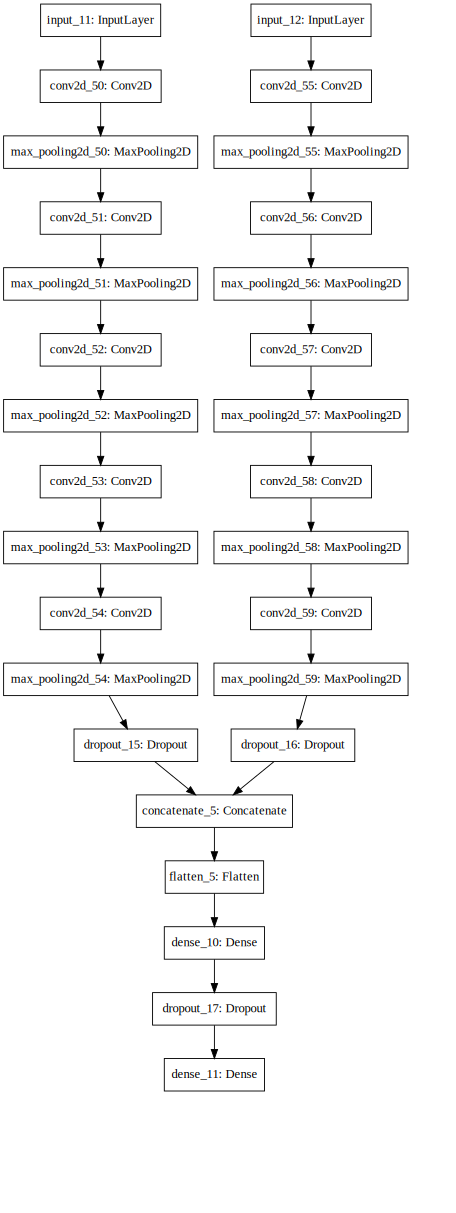

In [26]:
SVG(model_to_dot(model_reg, dpi = 65,rankdir = 'TB').create(prog='dot', format='svg'))

In [27]:
model_reg.fit([X_train_org_reg,X_train_tag_reg], y_train_reg, batch_size=128, epochs=15, verbose=1,
           validation_data=([X_cv_org_reg,X_cv_tag_reg], y_cv_reg))

Train on 3784 samples, validate on 568 samples
Epoch 1/15
3784/3784 [==============================] - ETA: 4:45 - loss: 0.5444 - mae: 0.699 - ETA: 5:24 - loss: 0.3601 - mae: 0.518 - ETA: 4:12 - loss: 0.2649 - mae: 0.421 - ETA: 3:30 - loss: 0.2222 - mae: 0.377 - ETA: 3:04 - loss: 0.1943 - mae: 0.346 - ETA: 2:45 - loss: 0.1757 - mae: 0.327 - ETA: 2:30 - loss: 0.1611 - mae: 0.310 - ETA: 2:18 - loss: 0.1504 - mae: 0.298 - ETA: 2:08 - loss: 0.1417 - mae: 0.288 - ETA: 1:58 - loss: 0.1346 - mae: 0.280 - ETA: 1:52 - loss: 0.1311 - mae: 0.275 - ETA: 1:44 - loss: 0.1311 - mae: 0.271 - ETA: 1:36 - loss: 0.1269 - mae: 0.267 - ETA: 1:29 - loss: 0.1220 - mae: 0.261 - ETA: 1:22 - loss: 0.1184 - mae: 0.257 - ETA: 1:15 - loss: 0.1154 - mae: 0.253 - ETA: 1:09 - loss: 0.1114 - mae: 0.249 - ETA: 1:03 - loss: 0.1086 - mae: 0.245 - ETA: 57s - loss: 0.1059 - mae: 0.241 - ETA: 52s - loss: 0.1026 - mae: 0.23 - ETA: 46s - loss: 0.1000 - mae: 0.23 - ETA: 40s - loss: 0.0978 - mae: 0.23 - ETA: 35s - loss: 0.0960 

3784/3784 [==============================] - ETA: 2:22 - loss: 0.0243 - mae: 0.121 - ETA: 2:16 - loss: 0.0277 - mae: 0.123 - ETA: 2:10 - loss: 0.0255 - mae: 0.121 - ETA: 2:05 - loss: 0.0276 - mae: 0.125 - ETA: 1:59 - loss: 0.0282 - mae: 0.127 - ETA: 1:54 - loss: 0.0266 - mae: 0.123 - ETA: 1:49 - loss: 0.0275 - mae: 0.126 - ETA: 1:44 - loss: 0.0267 - mae: 0.124 - ETA: 1:39 - loss: 0.0264 - mae: 0.124 - ETA: 1:34 - loss: 0.0257 - mae: 0.122 - ETA: 1:29 - loss: 0.0254 - mae: 0.122 - ETA: 1:24 - loss: 0.0251 - mae: 0.121 - ETA: 1:20 - loss: 0.0258 - mae: 0.121 - ETA: 1:15 - loss: 0.0256 - mae: 0.121 - ETA: 1:10 - loss: 0.0256 - mae: 0.121 - ETA: 1:05 - loss: 0.0254 - mae: 0.120 - ETA: 1:00 - loss: 0.0262 - mae: 0.121 - ETA: 56s - loss: 0.0264 - mae: 0.121 - ETA: 51s - loss: 0.0268 - mae: 0.12 - ETA: 46s - loss: 0.0267 - mae: 0.12 - ETA: 41s - loss: 0.0266 - mae: 0.12 - ETA: 37s - loss: 0.0267 - mae: 0.12 - ETA: 32s - loss: 0.0268 - mae: 0.12 - ETA: 27s - loss: 0.0269 - mae: 0.12 - ETA: 22s

In [28]:
test_score_reg, test_acc_reg = model_reg.evaluate([X_test_org_reg,X_test_tag_reg],y_test_reg)

379/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

 - 7s 18ms/sample - loss: 0.0170 - mae: 0.0971


In [29]:
print('Test score is :', test_score_reg)
print('Test mae is:', test_acc_reg)

Test mae is: 0.09712798
Test score is : 0.024581427302575207


In [30]:
yhat_test_reg = model_reg.predict([X_test_org_reg,X_test_tag_reg]) #predict_classes doesn't work for non sequential, returns % chance

In [31]:
np.block([yhat_test_reg,y_test_reg[:,np.newaxis]])

array([[1.25151575, 1.015     ],
       [0.85725528, 1.073     ],
       [0.78570914, 0.729     ],
       [0.85202622, 0.918     ],
       [1.18343914, 1.39      ],
       [0.78606933, 0.823     ],
       [1.14582384, 1.058     ],
       [0.64436257, 0.648     ],
       [0.83230835, 0.965     ],
       [0.6841563 , 0.726     ],
       [0.66512501, 0.733     ],
       [0.89490223, 1.119     ],
       [1.20646381, 1.053     ],
       [0.68310595, 0.635     ],
       [0.7024644 , 0.885     ],
       [0.86658412, 1.05      ],
       [1.14040077, 1.111     ],
       [0.7179417 , 0.802     ],
       [0.90803802, 1.03      ],
       [0.82846695, 0.745     ],
       [0.91454709, 0.919     ],
       [0.68395674, 0.899     ],
       [0.82702553, 0.88      ],
       [0.6193006 , 0.656     ],
       [0.78741634, 0.809     ],
       [1.03246665, 1.209     ],
       [0.89630961, 0.924     ],
       [0.98808473, 1.054     ],
       [0.81814152, 0.701     ],
       [0.84723294, 0.892     ],
       [0.

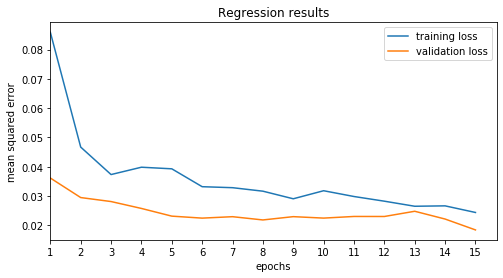

In [33]:
model_graphs(model_reg,regression=True)

In [43]:
randomizer = np.random.choice(X_train_tag_reg.shape[0], 100, replace=False)
background = [X_train_org_reg[randomizer],X_train_tag_reg[randomizer]]

# # explain predictions of the model on several images
e = shap.GradientExplainer(model_reg, background) #Deep Explainer doesn't work yet for tf 2.0

In [53]:
print(yhat_test_reg[103:109].flatten())
print(y_test_reg[103:109])

[0.727191   0.8472963  0.56906563 0.8976581  0.64854336 0.7913288 ]
[1.067 0.82  0.471 0.892 0.655 0.806]


In [ ]:
#We look at images predicted as no plaque and plaque
shap_values = e.shap_values([X_test_org_reg[103:109],X_test_tag_reg[103:109]])

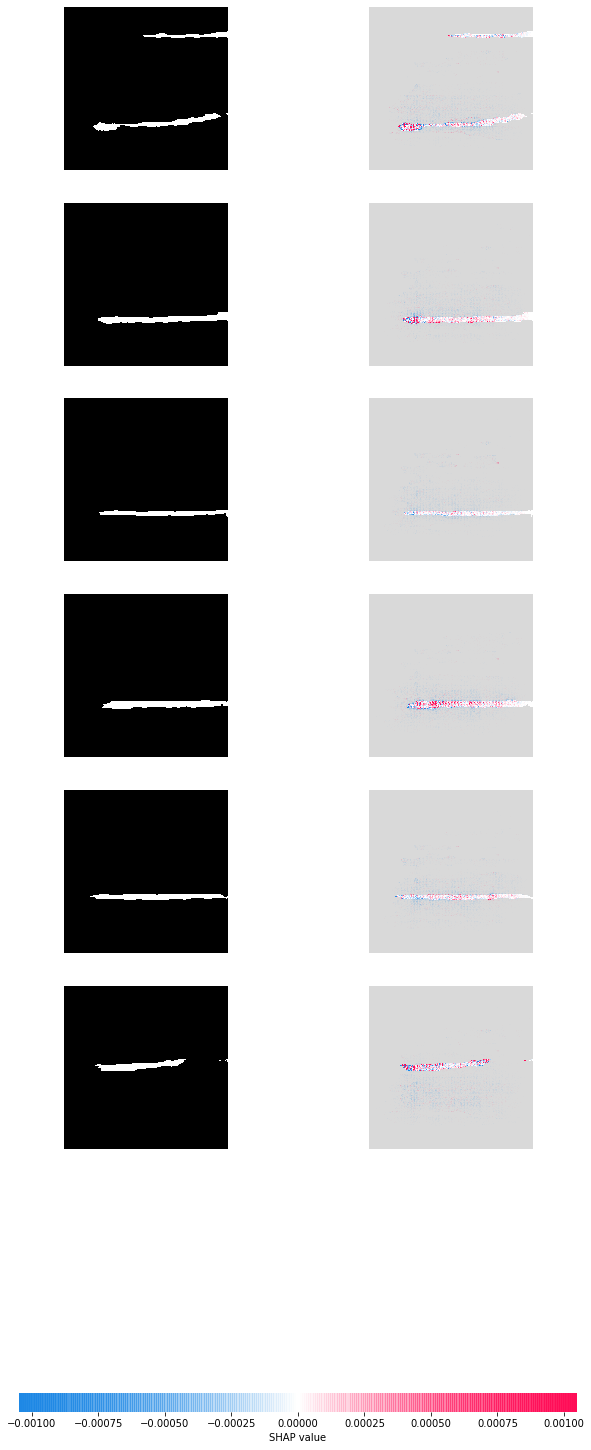

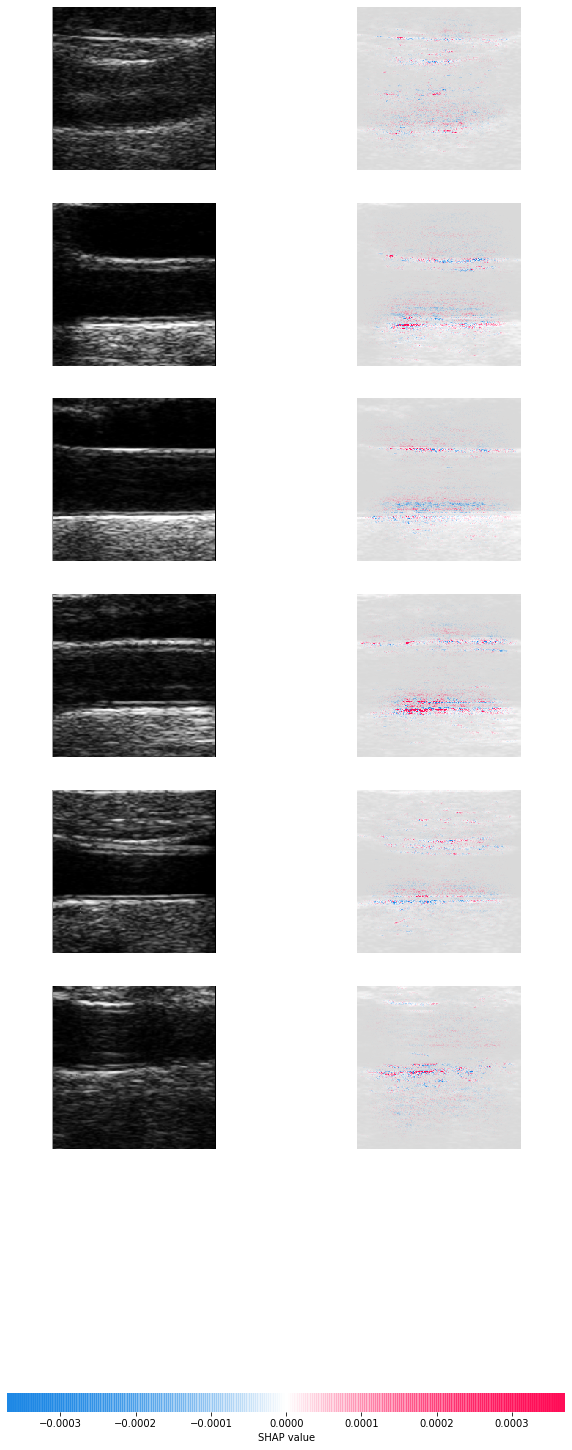

In [42]:
#Get one explanation for each input (in this case 2), and a len of 1 on shap values for 1 output
shap.image_plot([shap_values[0][1]], X_test_tag_reg[103:109],show=False) #Tag
fig = plt.gcf()
fig.set_size_inches((10, 30),forward = True)
# shap.image_plot([shap_values[0][i] for i in range(2)], X_test_org[103:109]) #Orginals
shap.image_plot([shap_values[0][0]], X_test_org_reg[103:109],show = False) #Orginals
fig = plt.gcf()
fig.set_size_inches((10, 30))

### Original image only model

In [16]:
nb_filters = 32
nb_pool = 2
nb_conv = 3

inputs = [X_train_org_reg]
nb_filters = 32
nb_pool = 2
nb_conv = 3

model_reg_single = Sequential(name = 'Org_image_model')

#Add max pooling layers for each convolution, and then pass the results through a dense layer, and output with a sigmoid

model_reg_single.add(Conv2D(nb_filters, (nb_conv, nb_conv), activation='relu', input_shape=inputs[0].shape[1:]))
model_reg_single.add(MaxPooling2D(pool_size=(nb_pool, nb_pool)))
model_reg_single.add(Conv2D(nb_filters, (nb_conv, nb_conv), activation='relu'))
model_reg_single.add(MaxPooling2D(pool_size=(nb_pool, nb_pool)))
model_reg_single.add(Conv2D(nb_filters, (nb_conv, nb_conv), activation='relu'))
model_reg_single.add(MaxPooling2D(pool_size=(nb_pool, nb_pool)))
model_reg_single.add(Conv2D(nb_filters, (nb_conv, nb_conv), activation='relu'))
model_reg_single.add(MaxPooling2D(pool_size=(nb_pool, nb_pool)))
model_reg_single.add(Conv2D(nb_filters, (nb_conv, nb_conv), activation='relu'))
model_reg_single.add(MaxPooling2D(pool_size=(nb_pool, nb_pool)))

model_reg_single.add(Dropout(0.25)) #Avoid overfitting
model_reg_single.add(Flatten()) # this converts the 3D feature maps to 1D feature vectors

model_reg_single.add(Dense(128, activation='relu'))
model_reg_single.add(Dropout(0.5)) #Avoid overfitting
model_reg_single.add(Dense(1, activation='relu'))

model_reg_single.compile(loss='mean_squared_error', optimizer='adam', metrics=['mae'])
model_reg_single.summary()


Model: "Org_image_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 222, 222, 32)      896       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 111, 111, 32)      0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 109, 109, 32)      9248      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 54, 54, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 52, 52, 32)        9248      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 26, 26, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 24, 24, 32)    

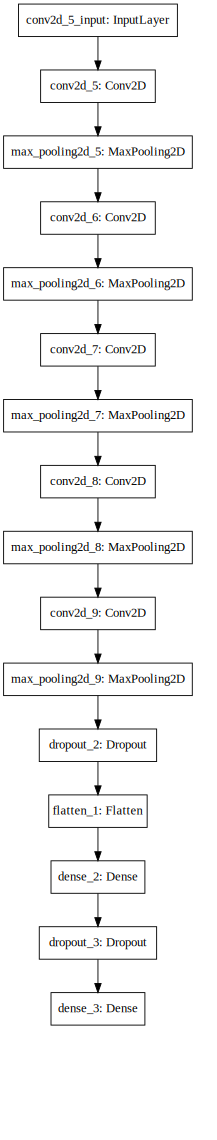

In [17]:
SVG(model_to_dot(model_reg_single, dpi = 65,rankdir = 'TB').create(prog='dot', format='svg'))

In [18]:
model_reg_single.fit(X_train_org_reg, y_train_reg, batch_size=128, epochs=15, verbose=1,
           validation_data=(X_cv_org_reg, y_cv_reg))

Train on 3784 samples, validate on 568 samples
Epoch 1/15
3784/3784 [==============================] - ETA: 7:18 - loss: 0.6820 - mae: 0.793 - ETA: 5:08 - loss: 0.5018 - mae: 0.630 - ETA: 4:24 - loss: 0.4129 - mae: 0.551 - ETA: 3:55 - loss: 0.3415 - mae: 0.484 - ETA: 3:29 - loss: 0.2920 - mae: 0.437 - ETA: 3:15 - loss: 0.2782 - mae: 0.424 - ETA: 3:00 - loss: 0.2681 - mae: 0.416 - ETA: 2:47 - loss: 0.2501 - mae: 0.398 - ETA: 2:36 - loss: 0.2360 - mae: 0.384 - ETA: 2:26 - loss: 0.2242 - mae: 0.373 - ETA: 2:17 - loss: 0.2158 - mae: 0.364 - ETA: 2:06 - loss: 0.2065 - mae: 0.355 - ETA: 1:56 - loss: 0.2013 - mae: 0.347 - ETA: 1:48 - loss: 0.1942 - mae: 0.340 - ETA: 1:38 - loss: 0.1886 - mae: 0.335 - ETA: 1:32 - loss: 0.1830 - mae: 0.329 - ETA: 1:25 - loss: 0.1768 - mae: 0.322 - ETA: 1:19 - loss: 0.1727 - mae: 0.318 - ETA: 1:12 - loss: 0.1690 - mae: 0.314 - ETA: 1:05 - loss: 0.1650 - mae: 0.310 - ETA: 58s - loss: 0.1612 - mae: 0.307 - ETA: 52s - loss: 0.1583 - mae: 0.30 - ETA: 45s - loss: 0.1

3784/3784 [==============================] - ETA: 3:06 - loss: 0.0288 - mae: 0.132 - ETA: 2:56 - loss: 0.0365 - mae: 0.144 - ETA: 2:51 - loss: 0.0367 - mae: 0.144 - ETA: 2:44 - loss: 0.0359 - mae: 0.140 - ETA: 2:37 - loss: 0.0382 - mae: 0.139 - ETA: 2:31 - loss: 0.0372 - mae: 0.139 - ETA: 2:24 - loss: 0.0359 - mae: 0.137 - ETA: 2:18 - loss: 0.0343 - mae: 0.134 - ETA: 2:12 - loss: 0.0340 - mae: 0.134 - ETA: 2:05 - loss: 0.0337 - mae: 0.133 - ETA: 1:59 - loss: 0.0329 - mae: 0.132 - ETA: 1:53 - loss: 0.0320 - mae: 0.131 - ETA: 1:46 - loss: 0.0323 - mae: 0.131 - ETA: 1:40 - loss: 0.0321 - mae: 0.131 - ETA: 1:33 - loss: 0.0318 - mae: 0.131 - ETA: 1:27 - loss: 0.0314 - mae: 0.130 - ETA: 1:21 - loss: 0.0311 - mae: 0.130 - ETA: 1:14 - loss: 0.0313 - mae: 0.130 - ETA: 1:08 - loss: 0.0310 - mae: 0.129 - ETA: 1:02 - loss: 0.0307 - mae: 0.128 - ETA: 55s - loss: 0.0302 - mae: 0.128 - ETA: 49s - loss: 0.0305 - mae: 0.12 - ETA: 42s - loss: 0.0309 - mae: 0.12 - ETA: 36s - loss: 0.0306 - mae: 0.12 - ET

In [19]:
test_score_reg2, test_acc_reg2 = model_reg_single.evaluate(X_test_org_reg,y_test_reg)

379/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

 - 13s 34ms/sample - loss: 0.0705 - mae: 0.1034


In [31]:
print('Test loss is :', test_score_reg2)
print('Test mae is:', test_acc_reg2)

Test loss is : 0.03712695491030851
Test mae is: 0.10342123


In [20]:
yhat_test_reg = model_reg_single.predict(X_test_org_reg) #predict_classes doesn't work for non sequential, returns % chance

In [21]:
np.block([yhat_test_reg,y_test_reg[:,np.newaxis]])

array([[1.25245726, 1.015     ],
       [0.96514291, 1.073     ],
       [0.73202312, 0.729     ],
       [0.92920095, 0.918     ],
       [1.34885585, 1.39      ],
       [0.76347113, 0.823     ],
       [1.16378367, 1.058     ],
       [0.62833768, 0.648     ],
       [1.06620169, 0.965     ],
       [0.62856066, 0.726     ],
       [0.58835286, 0.733     ],
       [0.91256624, 1.119     ],
       [1.09710681, 1.053     ],
       [0.63842154, 0.635     ],
       [0.68098348, 0.885     ],
       [0.96219176, 1.05      ],
       [1.2424022 , 1.111     ],
       [0.74985337, 0.802     ],
       [0.98303306, 1.03      ],
       [0.87268585, 0.745     ],
       [0.88256073, 0.919     ],
       [0.66521472, 0.899     ],
       [0.88439935, 0.88      ],
       [0.65166605, 0.656     ],
       [0.75091267, 0.809     ],
       [0.88886291, 1.209     ],
       [0.77587014, 0.924     ],
       [0.95234734, 1.054     ],
       [0.93496507, 0.701     ],
       [0.86667973, 0.892     ],
       [0.

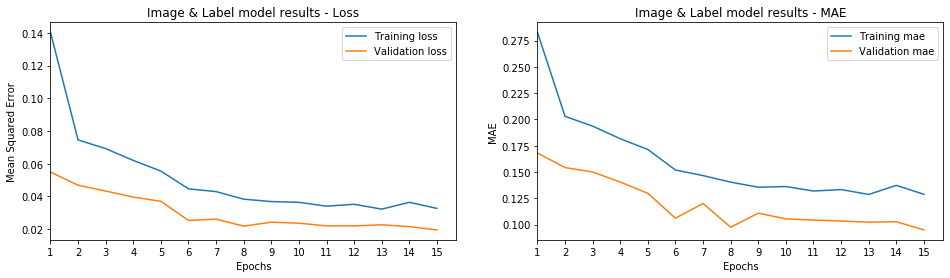

In [22]:
model_graphs(model_reg_single,regression = True)

In [23]:
background = X_train_org_reg[np.random.choice(X_train_tag_reg.shape[0], 100, replace=False)]

# # explain predictions of the model on several images
e = shap.GradientExplainer(model_reg_single, background) #Deep Explainer doesn't work yet for tf 2.0

In [24]:
print(yhat_test_reg[103:109].flatten())
print(y_test_reg[103:109])

[0.79047364 0.7776387  0.5703991  0.833645   0.6062342  0.8470256 ]
[1.067 0.82  0.471 0.892 0.655 0.806]


In [25]:
#We look at images predicted as no plaque and plaque
shap_values = e.shap_values(X_test_org_reg[103:109])

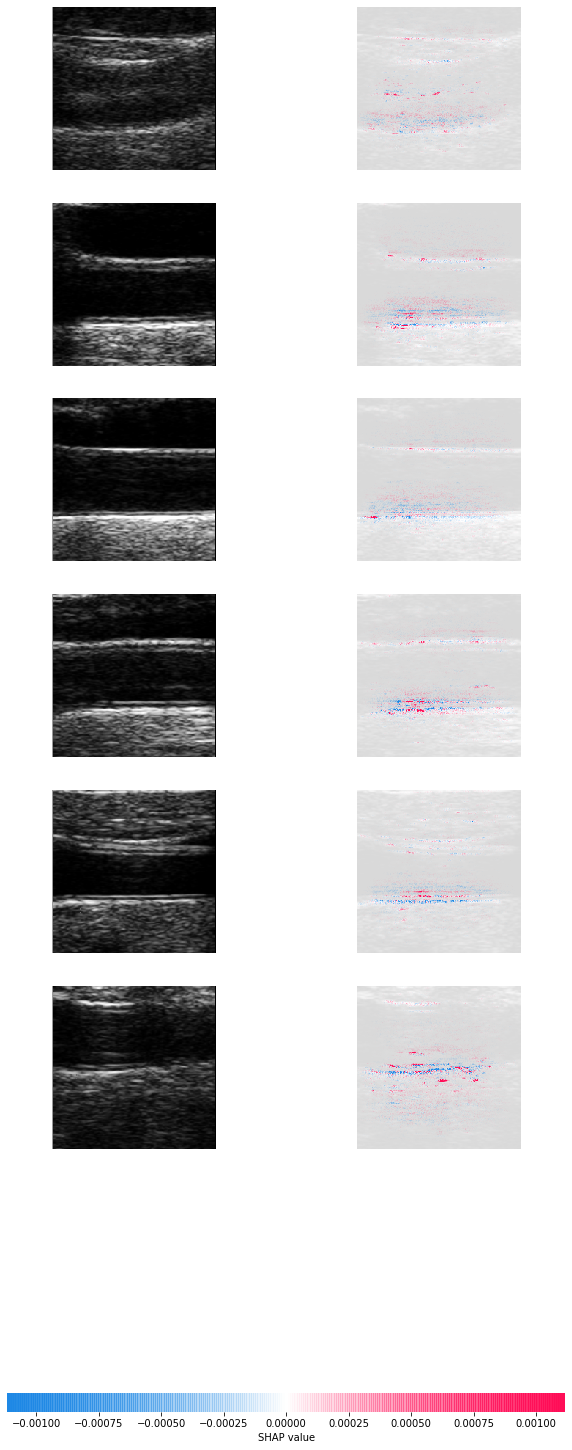

In [26]:
shap.image_plot(shap_values, X_test_org_reg[103:109],show = False) #Orginals
fig = plt.gcf()
fig.set_size_inches((10, 30))